In [ ]:
import os
import sys

In [ ]:
os.path.abspath(os.path.join('../'))

'c:\\Users\\H P\\Desktop\\Shopper_Spectrum_Customer_Segmentation'

# Importing required Libraries

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & Models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Similarity Measures for Recommendation
from sklearn.metrics.pairwise import cosine_similarity

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('../data/raw/online_retail.csv', encoding = 'latin1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France


# Dataset overview

In [ ]:
# Checking the shape of the dataset
df.shape

(541909, 8)

In [ ]:
# checking the first few rows of the dataset
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2022-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2022-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2022-12-01 08:34:00,1.69,13047.0,United Kingdom


In [ ]:
# checking the last few rows of the dataset
df.tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2023-12-09 12:50:00,3.75,12680.0,France
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2023-12-09 12:50:00,3.75,12680.0,France
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2023-12-09 12:50:00,1.95,12680.0,France
541902,581587,22629,SPACEBOY LUNCH BOX,12,2023-12-09 12:50:00,1.95,12680.0,France
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2023-12-09 12:50:00,4.15,12680.0,France
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2023-12-09 12:50:00,4.95,12680.0,France


In [ ]:
# checking the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# displaying basic statistics of the dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleaning

In [ ]:
# Before cleaning the data i will create a copy of the original dataframe
df_clean = df.copy()

In [ ]:
# checking for missing values
df_clean.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# removing the rows with missing CustomerID
df_clean = df_clean.dropna(subset=["CustomerID"])

# Filling out the missing values in 'Description' with 'Unknown'
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

In [ ]:
# checking the data after handling missing values
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
print(df_clean.columns.to_list())

['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [ ]:
# Removing the cancelled invoices number
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('c', na=False)]

In [ ]:
# Removing the invalid quantities and prices
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["UnitPrice"] > 0)]

In [ ]:
# Comparing the shape of the cleaned dataset with the original dataset
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Original dataset shape: {df.shape}")

Cleaned dataset shape: (397884, 8)
Original dataset shape: (541909, 8)


# Feature Engineering

In [ ]:
# Converting 'InvoiceDate' to datetime format
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

# Creating a new column 'TotalAmount' as Quantity * UnitPrice
df_clean["TotalAmount"] = df_clean["Quantity"] * df_clean["UnitPrice"]

df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Exploratory Data Analysis

## Transactions by Country

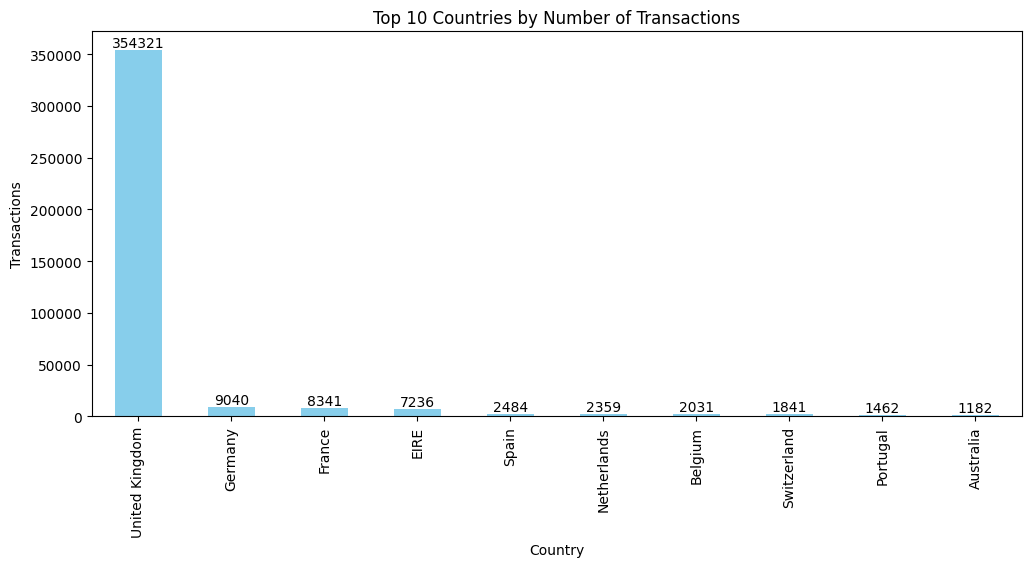

In [ ]:
# Trabsactions by Country

ax = df_clean["Country"].value_counts().head(10).plot(
    kind='bar', figsize=(12, 5), color='skyblue'
)

for c in ax.containers:
    ax.bar_label(c)

plt.title("Top 10 Countries by Number of Transactions")
plt.ylabel("Transactions")
plt.show()

## Top Selling Products

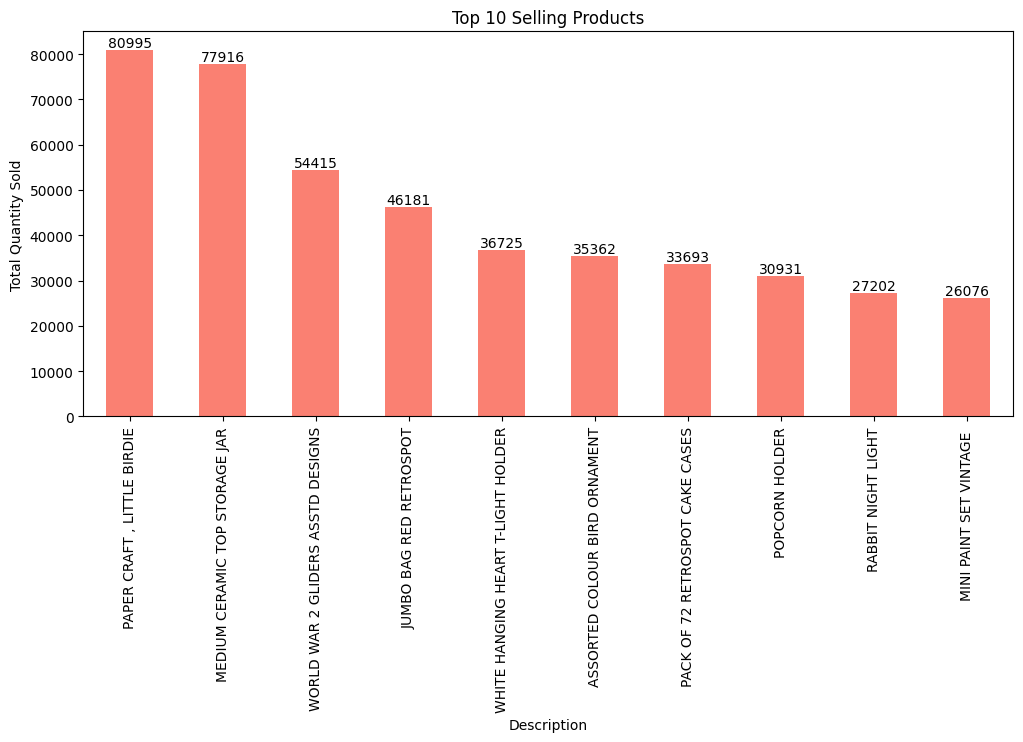

In [ ]:
# Top Selling Products
ax = df_clean.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10).plot(
    kind = "bar", figsize=(12,5), color='salmon'
)

for c in ax.containers:
    ax.bar_label(c)


plt.title("Top 10 Selling Products")
plt.ylabel("Total Quantity Sold")
plt.show()

## Monthly Purchase trends

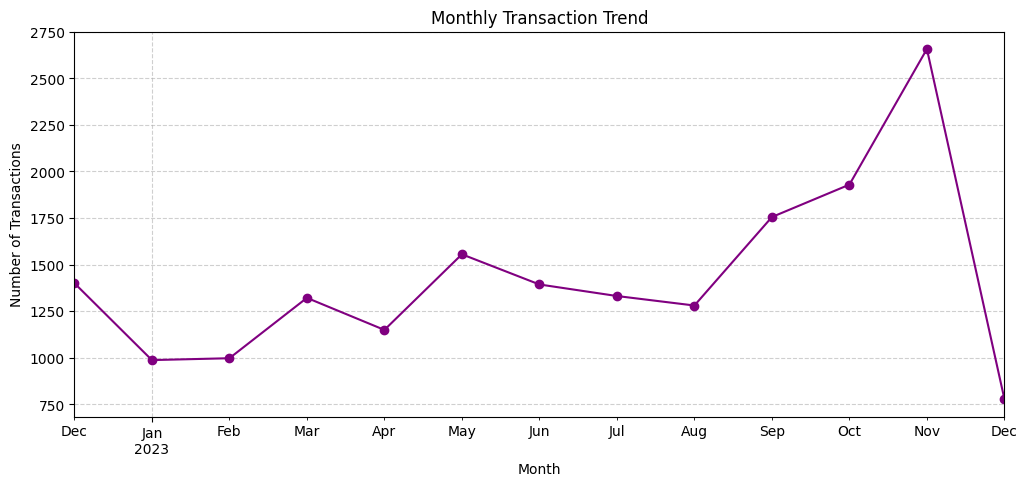

In [ ]:
# Monthly Purchase trends

ax = (
    df_clean.set_index("InvoiceDate").resample("M")["InvoiceNo"].nunique().plot(
        figsize=(12,5), marker='o', color='purple'
    )
)

plt.title("Monthly Transaction Trend")
plt.ylabel("Number of Transactions")
plt.xlabel("Month")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## Monetary per Transaction Distribution

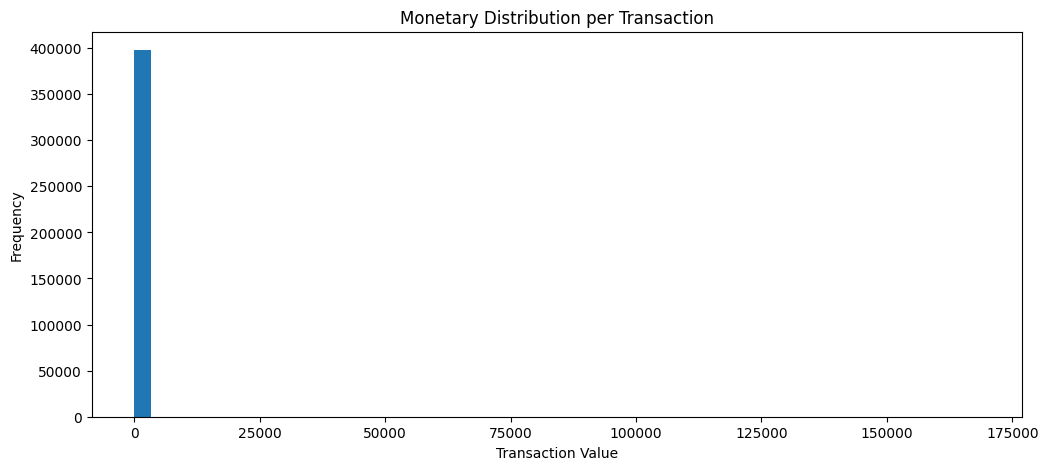

In [ ]:
# Monetary per Transaction Distribution

df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["UnitPrice"]

plt.figure(figsize=(12,5))
plt.hist(df_clean["TotalPrice"], bins=50)
plt.title("Monetary Distribution per Transaction")
plt.xlabel("Transaction Value")
plt.ylabel("Frequency")
plt.show()


## Monetary per Customer Distribution

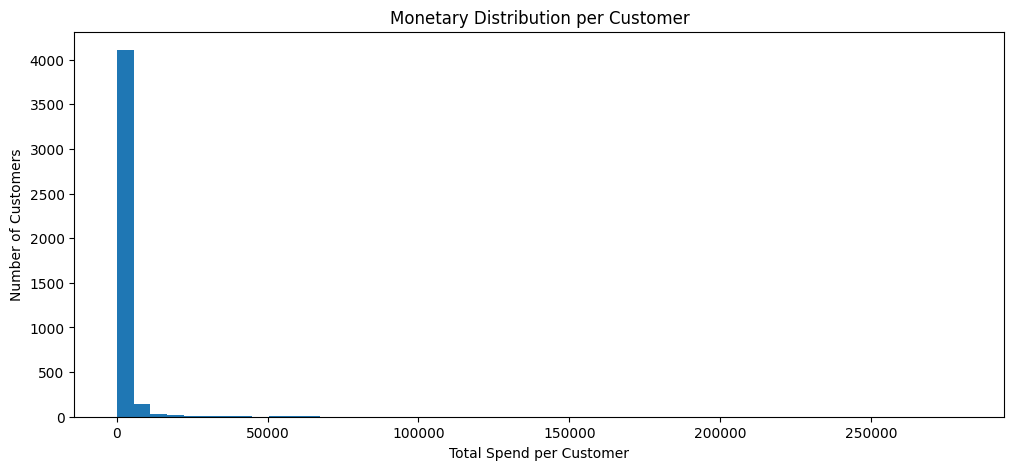

In [ ]:
# Monetary per Customer Distribution

customer_monetary = df_clean.groupby("CustomerID")["TotalPrice"].sum()

plt.figure(figsize=(12,5))
plt.hist(customer_monetary, bins=50)
plt.title("Monetary Distribution per Customer")
plt.xlabel("Total Spend per Customer")
plt.ylabel("Number of Customers")
plt.show()

## Creating a RFM Table

In [ ]:
# Creating RFM Table

snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df_clean.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Visualizing RFM Distributions

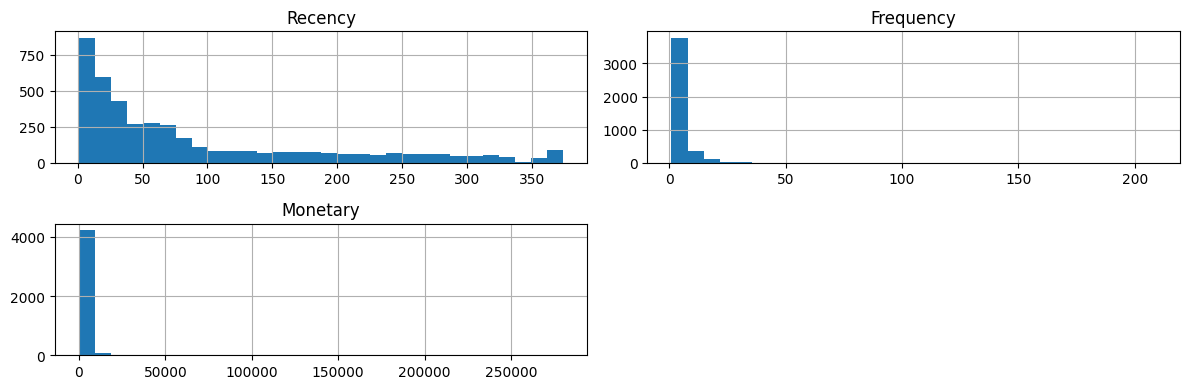

In [ ]:
# Visualizing RFM Distributions

rfm.hist(figsize=(12,4), bins=30)
plt.tight_layout()
plt.show()

In [ ]:
# Scaling RFM Values

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

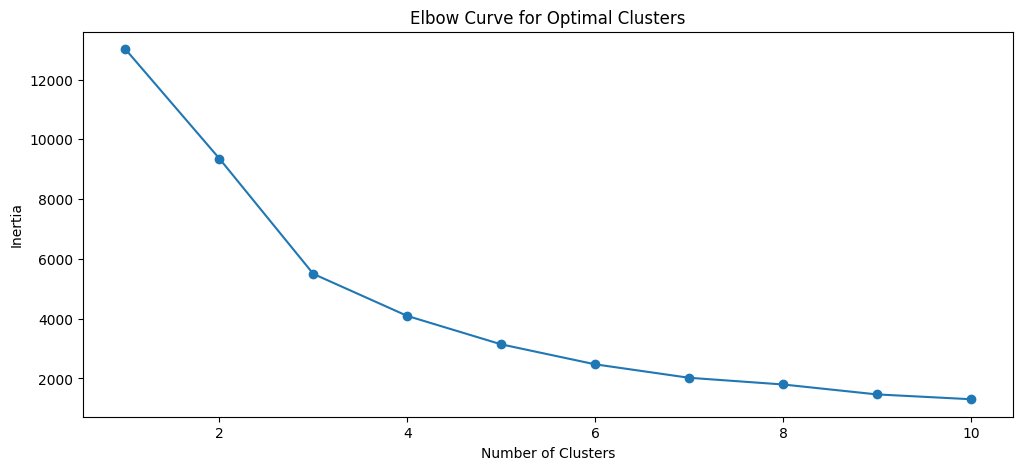

In [ ]:
# Elbow Method to find optimal K

inertia = []

for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(12,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Curve for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# fitting KMeans with optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [ ]:
# Cluster Profile Table
cluster_profile = rfm.groupby("Cluster").mean()
cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


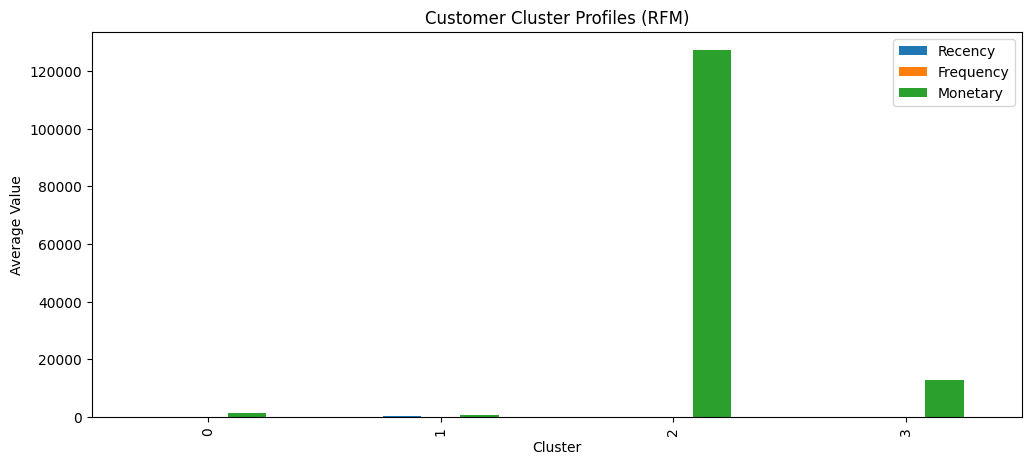

In [ ]:
# Visualizing Cluster Comparison

cluster_profile.plot(kind="bar", figsize=(12,5))
plt.title("Customer Cluster Profiles (RFM)")
plt.ylabel("Average Value")
plt.show()


## Product Recommendation Heatmap / Similarity matrix

In [ ]:
# Creating Customer-Product Matrix

customer_product = df_clean.pivot_table(
    index="CustomerID",
    columns="Description",
    values="Quantity",
    #aggfunc="sum",
    fill_value=0
)
#customer_product.head()

In [ ]:
# Product-product Similarity Matrix

product_similarity = cosine_similarity(customer_product.T)
similarity_df = pd.DataFrame(
    product_similarity,
    index=customer_product.columns,
    columns=customer_product.columns
)
#similarity_df.head()

In [ ]:
product_name = similarity_df.columns[0]

similarity_df[product_name].sort_values(ascending=False)[1:6]

Description
4 PINK DINNER CANDLE SILVER FLOCK    0.843391
BLACK MINI TAPE MEASURE              0.418047
PINK DIAMANTE PEN IN GIFT BOX        0.368003
LETTER "I" BLING KEY RING            0.296621
PINK/FLOWER RABBIT EGG WARMER        0.273471
Name:  4 PURPLE FLOCK DINNER CANDLES, dtype: float64

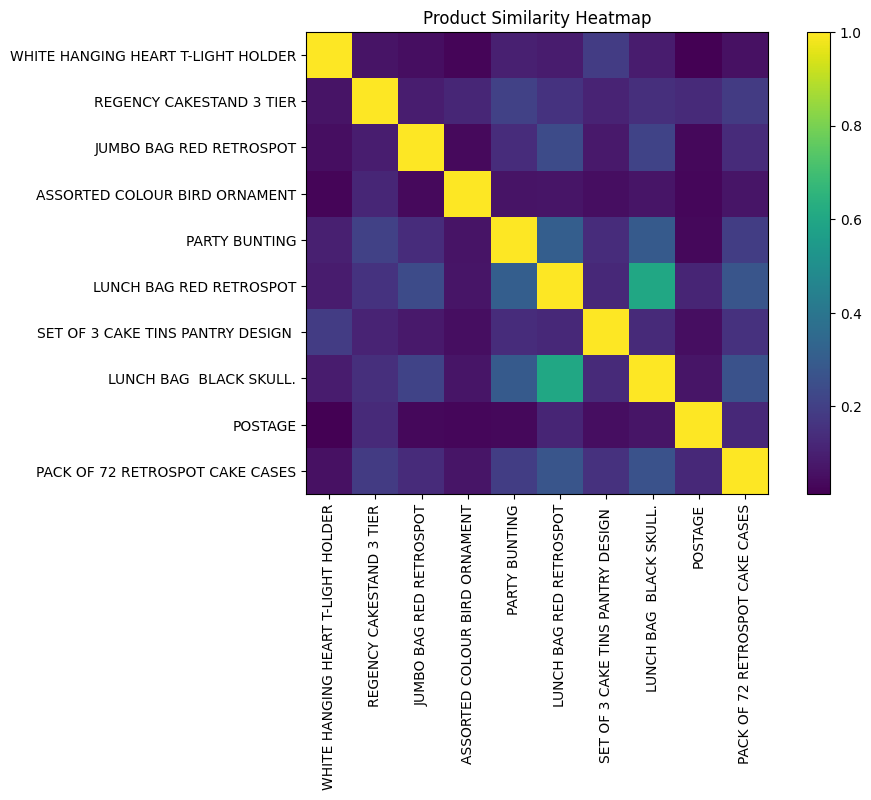

In [ ]:
# Heatmaps of Top Products

top_products = df_clean["Description"].value_counts().head(10).index
top_similarity = similarity_df.loc[top_products, top_products]

plt.figure(figsize=(10,6))
plt.imshow(top_similarity)
plt.colorbar()
plt.xticks(range(len(top_products)), top_products, rotation=90)
plt.yticks(range(len(top_products)), top_products)
plt.title("Product Similarity Heatmap")
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

rfm["DBSCAN_Cluster"].value_counts()

DBSCAN_Cluster
 0    4297
-1      41
Name: count, dtype: int64

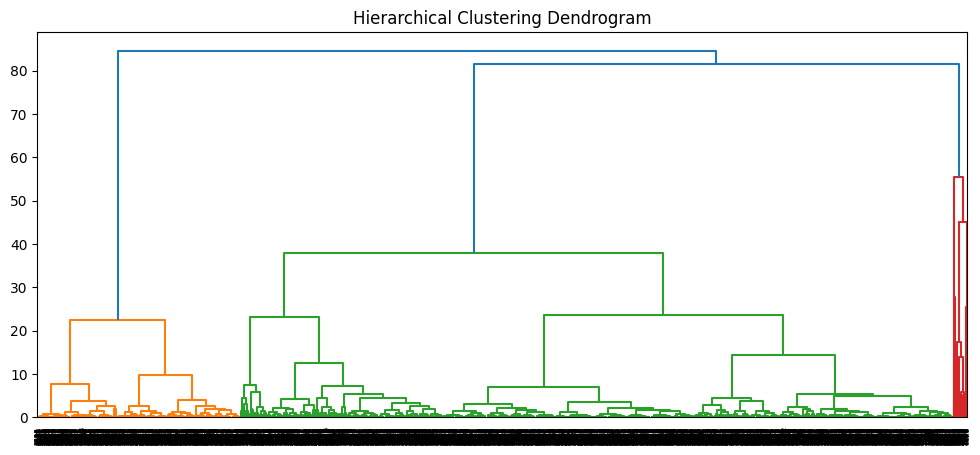

In [ ]:
linked = linkage(rfm_scaled, method="ward")

plt.figure(figsize=(12,5))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


In [ ]:
rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [ ]:
#from sklearn.metrics import silhouette_score

# KMeans Silhouette Score
kmeans_score = silhouette_score(rfm_scaled, rfm["Cluster"])

# DBSCAN Silhouette Score
dbscan_labels = rfm["DBSCAN_Cluster"]

if len(set(dbscan_labels)) > 1:
    dbscan_score = silhouette_score(rfm_scaled, dbscan_labels)
else:
    dbscan_score = "Not Applicable"

print("Silhouette Scores")
print("KMeans :", kmeans_score)
print("DBSCAN :", dbscan_score)
